Chiara Barbieri -- 517096

Lorenzo Zoppelletto -- 516124

# Network Analysis




## Needed libraries

In [ ]:
!pip install praw
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Standard Library
import json
from collections import Counter

# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Reddit API
import praw
from praw.models import MoreComments

# Google Colab
from google.colab import drive


In [ ]:
# Dropping the warning
import warnings
warnings.filterwarnings("ignore")

## Importing the dataset

In [ ]:
!gdown 1n2TiGFN-rDDfrh5NrF-LDJOfs47rmaYp -O runner_data.csv

Downloading...
From: https://drive.google.com/uc?id=1n2TiGFN-rDDfrh5NrF-LDJOfs47rmaYp
To: /content/runner_data.csv
100% 2.63M/2.63M [00:00<00:00, 184MB/s]


In [ ]:
df = pd.read_csv('runner_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               522 non-null    object 
 1   clicked              522 non-null    bool   
 2   comments             522 non-null    object 
 3   created_utc          522 non-null    object 
 4   edited               522 non-null    object 
 5   id                   522 non-null    object 
 6   is_original_content  522 non-null    bool   
 7   is_self              522 non-null    bool   
 8   locked               522 non-null    bool   
 9   name                 522 non-null    object 
 10  num_comments         522 non-null    int64  
 11  over_18              522 non-null    bool   
 12  permalink            522 non-null    object 
 13  saved                522 non-null    bool   
 14  score                522 non-null    int64  
 15  spoiler              522 non-null    boo

## Accessing Reddit credentials


Downloading Reddit credentials from a personal file

In [ ]:
!gdown 1UK21LgcuLxS1E6SzduluWj96oJDciHBS --output reddit_credentials.json

Downloading...
From: https://drive.google.com/uc?id=1UK21LgcuLxS1E6SzduluWj96oJDciHBS
To: /content/reddit_credentials.json
100% 146/146 [00:00<00:00, 593kB/s]


In [ ]:
with open("reddit_credentials.json") as f:
    credentials = json.load(f)

In [ ]:
reddit = praw.Reddit(client_id=credentials['CLIENT_ID'],
                     client_secret=credentials['SECRET_TOKEN'],
                     password=credentials['PASSWORD'],
                     user_agent='Tutorial by /user/SMA202324',
                     username=credentials['USERNAME'],
                     check_for_async=False)

print(reddit.user.me())

chiaraUni_unipv


# Build the graph

## Extracting more comments

A big Reddit post can have thousands of comments, so Reddit doesn't send them all at once (to avoid overloading the API).

For this reason, only the top-level comments and some placeholders are fetched. However, to build a more meaningful graph of the discussion, we also need to get the second and third levels of comments by expanding these placeholders.

In [ ]:
for index, i in df[10:20].iterrows():
  sub = reddit.submission(i['id'])
  for c in sub.comments:
    if isinstance(c, MoreComments):
      print(c.comments)
      print(sub.comments.replace_more(limit=20))
      break

The code above shows that the posts selected only contain top-level comments, and for this reason, MoreComments does not appear and nothing is printed. However, in the piece of code above we are not considering replies.

In [ ]:
count = 0

for _, row in df.iloc[10:20].iterrows():
    sub = reddit.submission(i['id'])
    sub.comments.replace_more(limit=None)   # expand placeholders: now replies are also considered
    for c in sub.comments.list():
        count += 1

print(f"Total number of comments fetched: {count}")

Total number of comments fetched: 2560


Now we can extract the pair of authors to connect the author of the post to the author of the comment.

In [ ]:
# Initializing the empty list for the pairs of authors
authors_rel = []

for index, i in df.iterrows():

  # Find author and comments
  sub_auth = i['author']
  sub = reddit.submission(i['id'])
  sub.comments.replace_more(limit=2) # Max third level comments

  # Extract author of each comment for top-level comments
  for top_level_comment in sub.comments:
    top_level_auth = top_level_comment.author
    authors_rel_element = [str(sub_auth),str(top_level_auth)]
    authors_rel.append(authors_rel_element)

    # Extract author of each comment for second-level comments
    for second_level_comment in top_level_comment.replies:
      sec_level_auth = second_level_comment.author
      authors_rel_element = [str(top_level_auth),str(sec_level_auth)]
      authors_rel.append(authors_rel_element)

      # Extract author of each comment for third-level comments
      for third_level_comment in second_level_comment.replies:
        third_level_auth = third_level_comment.author
        authors_rel_element = [str(sec_level_auth),str(third_level_auth)]
        authors_rel.append(authors_rel_element)

In [ ]:
print(f"We find {len(authors_rel)} authors' relations")

We find 90862 authors' relations


In [ ]:
# Creating a dataframe with the pairs of authors
relation_df = pd.DataFrame(authors_rel, columns=['Post_author','Comment_author'])

# Dropping the duplicate pairs
relation_df = relation_df.drop_duplicates()
# Cleaning from null values
relation_df = relation_df.mask(relation_df.eq('None')).dropna()
# Drop the authors who have commented in their own post
relation_df = relation_df[relation_df["Post_author"] != relation_df["Comment_author"]]

relation_df

Post_author       Comment_author
6              xenonscreams           shikibowow
8                     Can37          blue_lotion
9               blue_lotion           no_reverse
10               no_reverse         xenonscreams
11              blue_lotion                Can37
...                     ...                  ...
90857  Intelligent-Guard267         pbconspiracy
90858          pbconspiracy  MinimumAnalysis8814
90859   MinimumAnalysis8814         pbconspiracy
90860            bachfanwpb        johnniewelker
90861            bachfanwpb          OddSign2828

[71179 rows x 2 columns]

In [ ]:
#drive.mount("/content/drive", force_remount=True)

#relation_df.to_csv("/content/drive/MyDrive/AI/Year 3/Web and social networks search and analysis/Project/Authors_pairs.csv", index=False)

Mounted at /content/drive


## Building the graph

In [ ]:
!gdown 1qnslc5yOK-6mBCgfsPYNuhkkvXHfH9pf -O Authors_pairs.csv

Downloading...
From: https://drive.google.com/uc?id=1qnslc5yOK-6mBCgfsPYNuhkkvXHfH9pf
To: /content/Authors_pairs.csv
100% 1.85M/1.85M [00:00<00:00, 92.3MB/s]


In [ ]:
authorsPairs = pd.read_csv('Authors_pairs.csv')
authorsPairs.head()

Post_author Comment_author
0  xenonscreams     shikibowow
1         Can37    blue_lotion
2   blue_lotion     no_reverse
3    no_reverse   xenonscreams
4   blue_lotion          Can37

In [ ]:
# Creating an empty undirected graph
G = nx.Graph()

for index, r in authorsPairs.iterrows():
  G.add_edge(r['Post_author'],r['Comment_author'])

Since it is a very big graph, the nodes with the lowest degree will undergo vertex deletion. In this step, the goal is to obtain a more meaningful subgraph. Moreover, we will also delete the isolated nodes.

In [ ]:
# Keep the nodes with degree ≥ 3
min_deg = 3
to_remove = [n for n, d in dict(G.degree()).items() if d < min_deg]
# Apply vertex deletion on the selected nodes
G.remove_nodes_from(to_remove)

# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

print(f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

The graph has 8113 nodes and 29001 edges


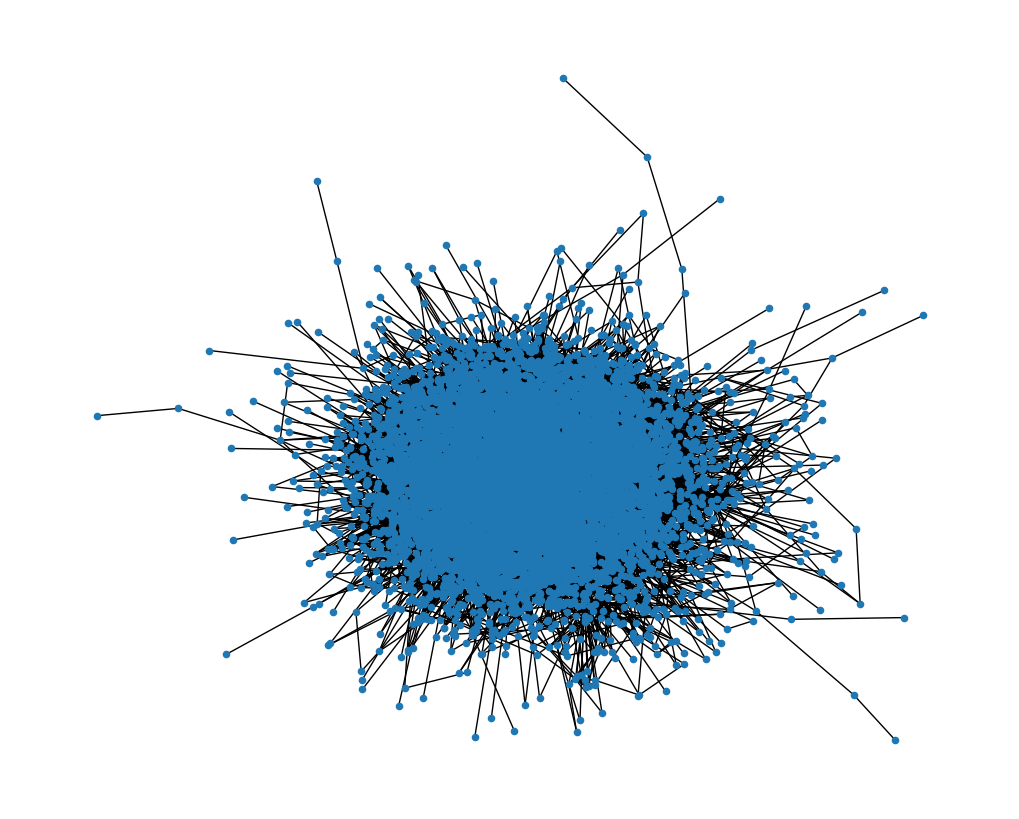

In [ ]:
# Plot the final graph G
plt.figure(figsize=(10,8))
nx.draw(G, node_size=20, with_labels=False)
plt.show()

In [ ]:
# Mount Google Drive
#drive.mount('/content/drive')
#save_path = "/content/drive/MyDrive/AI/Year 3/Web and social networks search and analysis/Project/my_graph.edgelist"

# Save graph
#nx.write_edgelist(G, save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Graph metrics

There are 3 main families of metrics:
- **Connection metrics**: ways in which social network entities connect with each other.
- **Distribution metrics**: ways in which information can flow within a social network.
- **Segmentation metrics**: ways of grouping the components of the social network.

Before we start computing the metrics, we download the graph defined above so that the following section can run independently from the others.

In [ ]:
!gdown 13NyoEDjVI0ahs_1NFz0_LJWMRtwbRz3G -O graph.edgelist

Downloading...
From: https://drive.google.com/uc?id=13NyoEDjVI0ahs_1NFz0_LJWMRtwbRz3G
To: /content/graph.edgelist
100% 835k/835k [00:00<00:00, 46.4MB/s]


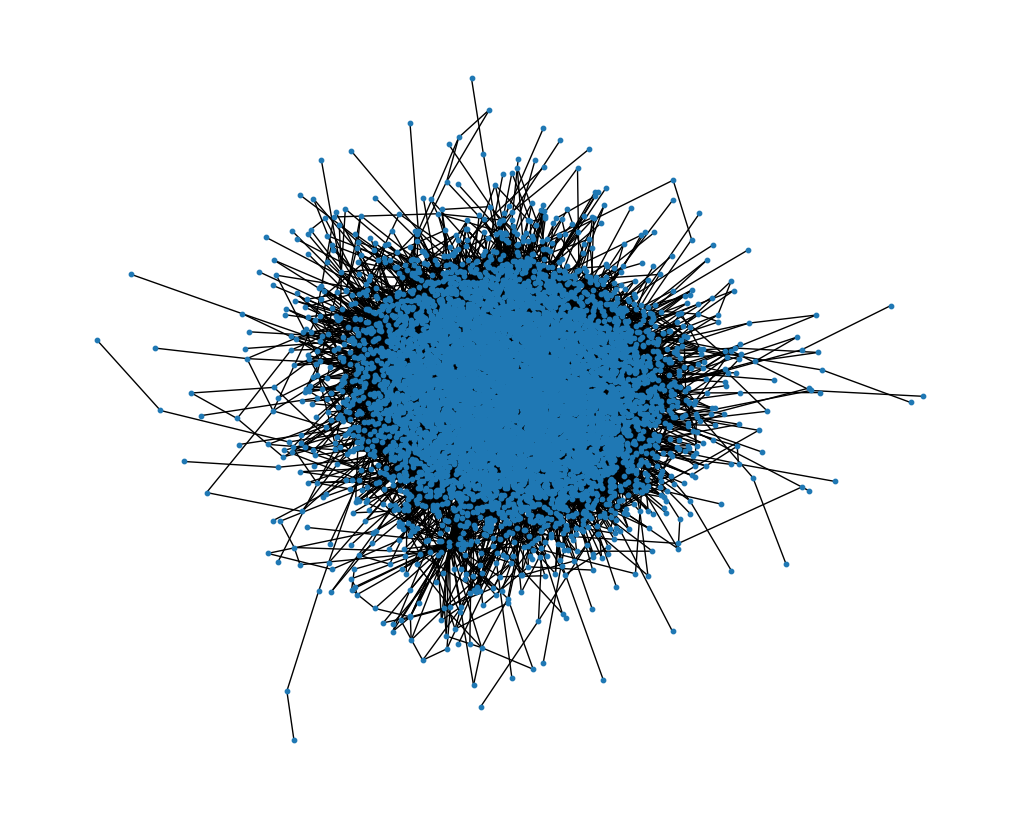

In [ ]:
# Load graph
plt.figure(figsize=(10, 8))
G = nx.read_edgelist("graph.edgelist")
nx.draw(G, node_size=10, with_labels=False)
plt.show()

For the purpose of this analysis, we need a few most important attributes present with the informations on the nodes.

In [ ]:
# For the attribute "category"
category_dict = df.set_index("author")["category"].to_dict()
nx.set_node_attributes(G, category_dict, "category")

# For the attribute "created_utc"
created_utc_dict = df.set_index("author")["created_utc"].to_dict()
nx.set_node_attributes(G, created_utc_dict, "created_utc")

# For the attribute "upvote_ratio"
upvote_ratio_dict = df.set_index("author")["upvote_ratio"].to_dict()
nx.set_node_attributes(G, upvote_ratio_dict, "upvote_ratio")

# For the attribute "count_comments"
count_comments_dict = df.set_index("author")["count_comments"].to_dict()
nx.set_node_attributes(G, count_comments_dict, "count_comments")

## Connection metrics

First of all, we check if the nodes are connected, so if there is a path between every pair of nodes.

In [ ]:
nx.is_connected(G)

True

In [ ]:
# Finding the connected components and ordering them by size
connected_components = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
len(connected_components)

1

From the results above we conclude that our graph is fully connected, it has only one connected component.

### Homophily

Homophily is the extent to which actors form ties with similar versus dissimilar actors. In a graph, this concept is often captured by assortativity coefficients, which can be both degree-based or attribute based.

If the score of assortativity is +1, then we have perfect homophily, while if the score is -1, then we have perfect heterophily.

In [ ]:
r_degree = nx.degree_assortativity_coefficient(G)
print("Degree assortativity:", r_degree)

Degree assortativity: -0.12840767235489287


In [ ]:
category_attr = nx.attribute_assortativity_coefficient(G, 'category')
print("Attribute assortativity (category):", category_attr)

Attribute assortativity (category): -0.23097308473668796


In [ ]:
created_utc_attr = nx.attribute_assortativity_coefficient(G, 'created_utc')
print("Attribute assortativity (created_utc):", created_utc_attr)

Attribute assortativity (created_utc): -0.18927869647147974


In [ ]:
upvote_ratio_attr = nx.attribute_assortativity_coefficient(G, 'upvote_ratio')
print("Attribute assortativity (upvote_ratio):", upvote_ratio_attr)

Attribute assortativity (upvote_ratio): -0.21256481223453427


In [ ]:
count_comments_attr = nx.attribute_assortativity_coefficient(G, 'count_comments')
print("Attribute assortativity (count_comments):", count_comments_attr)

Attribute assortativity (count_comments): -0.18986135879909477


All the assortatives scores are negative and close to 0, this means that we have heterophily that is close to be random mixing.

### Network closure

With network closure we refer to the concept of triadic closure, which is a property that 3 nodes can have. This property states that if there is a strong tie between A-B and A-C, then there is a strong or weak tie between B-C.

The two most common measures to evaluate the triadic closure are:
- Clustering coefficient (local or average)
- Transitivity (global clustering coefficient)

In [ ]:
# Average clustering coefficient -- Closure across the network
avg_closure = nx.average_clustering(G)
print("Average closure:", avg_closure)

Average closure: 0.07791696225849742


Around 8% of the possible triangles around a node are actually close, so the local neighbourghoods are quite open.

In [ ]:
# Global clustering coefficient -- Global closure (transitivity)
global_closure = nx.transitivity(G)
print("Global closure:", global_closure)

Global closure: 0.008783251419683615


Only about 1% of all the possible triads are closed within the graph.

The results show that the network has very low overall closure, so low cohesion: users reply to a post but don't interact with each other.

## Distribution metrics

### Bridges and articulation points

We identify bridges to select the authors connecting otherwise separated communities. The goal here is to evaluate the strength of a tie, since they typically represent weak ties.

In [ ]:
bridges = list(nx.bridges(G))
print("Number of bridges found:", len(bridges))

Number of bridges found: 281


With articulation points we find the authors that are influencial and whose absence might fragment the discussions.

In [ ]:
articulation_points = list(nx.articulation_points(G))
print("Number of articulation points found:", len(articulation_points))

Number of articulation points found: 237


Overall, the results suggest that the network has low robustness, because few users and ties play a central role in maintaining cohesion. This means that the connectivity heavily depends on only a small subset of nodes and edges.

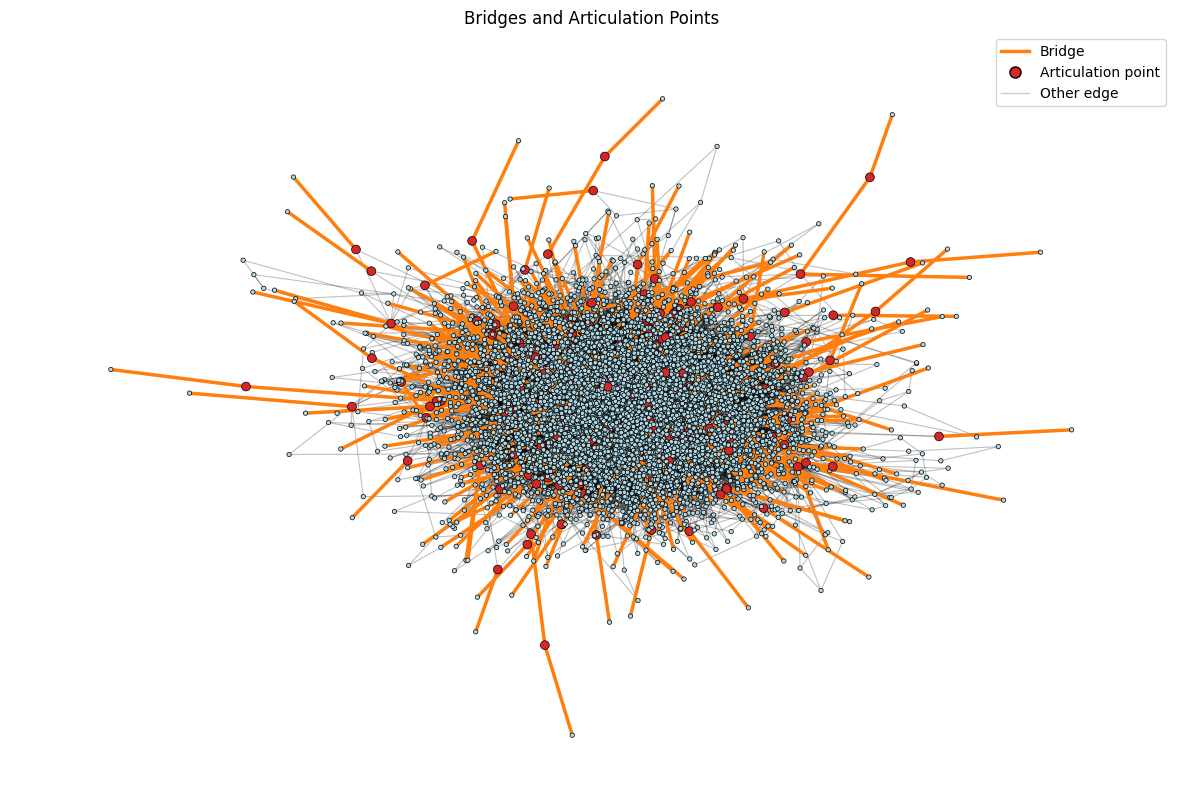

In [ ]:
plt.figure(figsize=(15,10))
pos = nx.spring_layout(G, seed=42)

# Defining the colors
node_colors = ["tab:red" if n in articulation_points else "lightblue" for n in G.nodes()]
node_sizes  = [40 if n in articulation_points else 10 for n in G.nodes()]
# Plotting the nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, linewidths=0.5, edgecolors="k")

# Plotting the base graph
default_edges = [e for e in G.edges() if e not in bridges and (e[1], e[0]) not in bridges]
nx.draw_networkx_edges(G, pos, edgelist=default_edges, width=0.8, alpha=0.25)

# Plotting the bridges
nx.draw_networkx_edges(G, pos, edgelist=bridges, width=2.5, edge_color="tab:orange")

# Adding the legend
legend_elements = [
    Line2D([0], [0], color="tab:orange", lw=2.5, label="Bridge"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor="tab:red", markeredgecolor="k", markersize=8, label="Articulation point"),
    Line2D([0], [0], color="gray", lw=1, alpha=0.4, label="Other edge")
]
plt.legend(handles=legend_elements, loc="best")
plt.axis("off")
plt.title("Bridges and Articulation Points")
plt.show()

### Centrality

The centrality indicators identify the most influencial vertices within a graph.

There are different centrality indicators, these are:
- Degree centrality
- Closeness centrality
- Betweenness centrality
- Delta centrality

The Degree centrality is defined as the number of edges incident to a node.

In [ ]:
# Normalized degree centrality
deg_cent = nx.degree_centrality(G)

# Top-10 authors with highest degree centrality
top_deg_cent = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
top_deg_cent

[('brwalkernc', 0.08604536489151875),
 ('Petrie345', 0.021079881656804734),
 ('countrymac96', 0.020093688362919134),
 ('lifeincoolcolours', 0.019847140039447733),
 ('isitmeaturlooking4', 0.019230769230769232),
 ('Jemmers88', 0.019230769230769232),
 ('Wingman0616', 0.01910749506903353),
 ('adscott1982', 0.017628205128205128),
 ('runner9272737373', 0.017504930966469427),
 ('nhrunner87', 0.016888560157790927)]

Closeness centrality is based on the length of the shortest paths from an author, since it means that the node is close to many other nodes

In [ ]:
# Closeness centrality
close_cent = nx.closeness_centrality(G)

# Top-10 authors with highest closeness centrality
top_close_cent = sorted(close_cent.items(), key=lambda x: x[1], reverse=True)[:10]
top_close_cent

[('brwalkernc', 0.39260478172490565),
 ('MichaelV27', 0.38244307199094807),
 ('pony_trekker', 0.36869375511317154),
 ('agreeingstorm9', 0.3619328068531656),
 ('zyzzogeton', 0.3476919120483477),
 ('MisterIntentionality', 0.34754295017351444),
 ('Wipe_face_off_head', 0.3428426524660834),
 ('Petrie345', 0.3422062855937566),
 ('kfh227', 0.3400117361052896),
 ('adscott1982', 0.33952787543947766)]

The Betweenness centrality counts the number of shortest paths a vertex is part of as a measure of centrality. It finds the authors that act as a bridge between other authors.

In [ ]:
# Betweenness centrality
bet_cent = nx.betweenness_centrality(G)

# Top-10 authors with highest betweenness centrality
top_bet_cent = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:10]
top_bet_cent

[('brwalkernc', 0.16451006054209014),
 ('MichaelV27', 0.03830681792659386),
 ('pony_trekker', 0.024981422237103052),
 ('Petrie345', 0.0188402468057455),
 ('agreeingstorm9', 0.017541816114335952),
 ('lifeincoolcolours', 0.017102305377011323),
 ('countrymac96', 0.01689783582721696),
 ('zyzzogeton', 0.016809233114403754),
 ('adscott1982', 0.016463104907213942),
 ('Jemmers88', 0.016147406062438224)]

For Delta centrality, the main idea is that the importance of a node can be measured by its contribution to the performance of the entire network. In fact, it is calculated by comparing the performance of the graph with the performance of the graph without the node. However, we have too many nodes to be able to compute it in a reasonable amount of time.

Having computed the centrality metrics, we have found the most influencial authors.

### Density

The density of a graph is measured to be able to distinguish between dense graphs and sparse graphs. Therefore, it helps understand whether a network is highly connected and redundant or it is loosely connected and fragmented.

In [ ]:
density = nx.density(G)
density

0.0008813198482674822

To further understand the cohesion of the graph, we will compare the density with the local clustering coefficient.

In [ ]:
local_clustering_coeff = nx.clustering(G)
local_clustering_coeff

{'Can37': 0,
 'blue_lotion': 0,
 'IDontCareAboutYourPR': 0,
 'aRhythMetic': 0,
 'Aleriya': 0,
 'rckid13': 0.017533606078316773,
 'jondiced': 0,
 'DisregardMyComment': 0.10714285714285714,
 'supaphly42': 0,
 'runner9272737373': 0.002097692538207971,
 'Zealousideal-One1020': 0.006245662734212352,
 '113wash': 0,
 'HissandVinegar': 0.16666666666666666,
 'crwper': 0,
 'steve_yo': 0,
 'NoldorInExile': 0,
 'laideybug': 0.038461538461538464,
 'thr33beggars': 0,
 'DingDongerer': 0,
 '6to8design': 0.004341164453524004,
 'fulgrimsleftnut': 0.1,
 'JoeTModelY': 0.015151515151515152,
 'Smallislandrunner': 0.006349206349206349,
 'FirstTime5k': 0.06666666666666667,
 'Bloomingcacti': 0,
 'withflyingcolors10': 0.1,
 'fatloui': 0.16666666666666666,
 'LogicalMacaroon': 0.09523809523809523,
 'ithinkitsbeertime': 0.09523809523809523,
 'NeonYellowShoes': 0,
 'wedAVL2019': 0,
 'UltraTrailCoach': 0.003952569169960474,
 'Mosquitoshite': 0,
 'apoohwa': 0.0015530964861192001,
 'summybsioa': 0.003202928391672386,


In [ ]:
min_local_clustering_coeff = min(local_clustering_coeff.values())
max_local_clustering_coeff = max(local_clustering_coeff.values())

print(f"Range of the clustering coefficients: {min_local_clustering_coeff} - {max_local_clustering_coeff}")

Range of the clustering coefficients: 0 - 1.0


The network has a very low overall density (around 0.9%), this means that the graph is highly sparse.

On the other hand, the local clustering coefficients vary widely, since they have a range from 0, so some nodes have no interconnections with their neighbours, to 1, some other nodes show tight subgroups.

This suggests that although the network lacks global cohesion, it contains pockets of strong local cohesion (cliques or small communities).

### Distance

The distance is the minimum of ties necessary to connect two authors. To better understand the flow of information within the graph, we will compute the distance between the most influential authors (found in the centrality computation).

In [ ]:
# Extract the name of the actors
influential_authors = [author for author, _ in list(top_deg_cent) + list(top_close_cent) + list(top_bet_cent)]

# Remove duplicates while keeping the order
influential_authors = list(dict.fromkeys(influential_authors))

# Print the name of the most influential auhtors
influential_authors

['brwalkernc',
 'Petrie345',
 'countrymac96',
 'lifeincoolcolours',
 'isitmeaturlooking4',
 'Jemmers88',
 'Wingman0616',
 'adscott1982',
 'runner9272737373',
 'nhrunner87',
 'MichaelV27',
 'pony_trekker',
 'agreeingstorm9',
 'zyzzogeton',
 'MisterIntentionality',
 'Wipe_face_off_head',
 'kfh227']

In [ ]:
if len(influential_authors) > 1:
  max_distance = 0
  min_distance = float('inf')
  for i in range(len(influential_authors)):
    for j in range(i+1, len(influential_authors)):
      distance = nx.shortest_path_length(G, source=influential_authors[i], target=influential_authors[j])
      # print(f"The distance between {influential_authors[i]} and {influential_authors[j]} is {distance}")
      if distance > max_distance:
        max_distance = distance
      if distance < min_distance:
        min_distance = distance

print(f"The maximum distance is {max_distance}")
print(f"The minimum distance is {min_distance}")

The maximum distance is 3
The minimum distance is 1


The distance between influential authors ranges from 1 to 3, this means that the group of influencial actors is relatively cohesive and integrative.
This suggests a small world structure, so any information can spread quickly across the influencial actors (and consequentially to the other users).

The overall eccentricity of the graph can be visualized in the cell of code below.

In [ ]:
eccentricity = nx.eccentricity(G)
print(eccentricity)

max_eccentricity = max(eccentricity.values())
min_eccentricity = min(eccentricity.values())
print(f"The range is {min_eccentricity} - {max_eccentricity}")

{'Can37': 7, 'blue_lotion': 8, 'IDontCareAboutYourPR': 8, 'aRhythMetic': 8, 'Aleriya': 8, 'rckid13': 7, 'jondiced': 8, 'DisregardMyComment': 7, 'supaphly42': 8, 'runner9272737373': 7, 'Zealousideal-One1020': 7, '113wash': 7, 'HissandVinegar': 7, 'crwper': 8, 'steve_yo': 8, 'NoldorInExile': 8, 'laideybug': 7, 'thr33beggars': 7, 'DingDongerer': 7, '6to8design': 7, 'fulgrimsleftnut': 8, 'JoeTModelY': 7, 'Smallislandrunner': 7, 'FirstTime5k': 7, 'Bloomingcacti': 8, 'withflyingcolors10': 7, 'fatloui': 8, 'LogicalMacaroon': 7, 'ithinkitsbeertime': 7, 'NeonYellowShoes': 7, 'wedAVL2019': 8, 'UltraTrailCoach': 7, 'Mosquitoshite': 7, 'apoohwa': 7, 'summybsioa': 7, 'silverblackgold': 7, 'GorillaJuiceOfficial': 7, 'AlarmingNectarine': 8, 'jlb1705': 8, 'isitmeaturlooking4': 7, 'TehFuriousOne': 8, 'EmergencySundae': 7, 'Lauzz91': 7, 'jonbornoo': 7, 'humbalo': 7, 'Falawful_17': 8, 'venomous_frost': 8, 'Rickyv490': 7, 'LittleSadRufus': 8, 'Platypus_Attack_Cat': 7, 'Your_moms_throw_away': 7, 'Grantsdal

From the result of the computation of the distance between the influential nodes and the eccentricity, we conclude that the graph follows a star network structure (or at least a core-periphery structure), since there are few influential (central) nodes that are close to everyone else and many leaf (peripherical) nodes that are connected through those hubs.

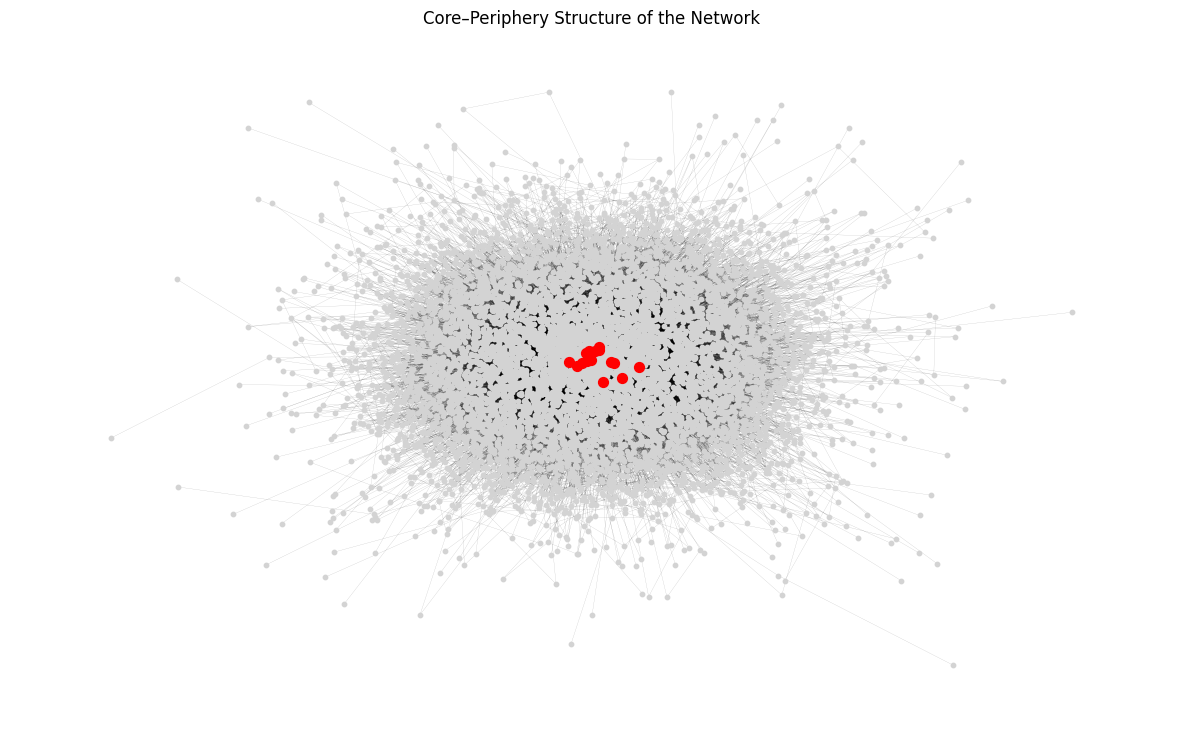

In [ ]:
# Position of the nodes
pos = nx.spring_layout(G, iterations=20)

plt.subplots(figsize=(15, 9))

# First we draw the peripheral (gray) nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=[n for n in G.nodes() if n not in influential_authors],
    node_color="lightgrey",
    node_size=10
)

# Then draw the influential (red) nodes on top
nx.draw_networkx_nodes(
    G, pos,
    nodelist=influential_authors,
    node_color="red",
    node_size=50
)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.15)

plt.title("Core–Periphery Structure of the Network")
plt.axis("off")
plt.show()


## Segmentation metrics

### Counting the Cliques

A clique is a subset of nodes where everyone is directly connected to everyone else. Therefore, counting cliques tells us how many completely interconnected subgroups exist. It is a way to measure cohesion, redundancy and density of the substructures.

In [ ]:
cliques = list(nx.find_cliques(G))
print('Amount of Maximal cliques:', len(cliques))

Amount of Maximal cliques: 25059


In [ ]:
# Count the length of each clique found
def count_len():
  l = []
  for i in cliques:
    l.append(len(i))
  return l
clique_lengths = count_len()

# Find how many ciques have the same size
clique_size_counts = Counter(clique_lengths)

print("Number of cliques for each size:")
for size, count in sorted(clique_size_counts.items()):
    print(f"Size {size}: {count} cliques")

Number of cliques for each size:
Size 2: 21900 cliques
Size 3: 3107 cliques
Size 4: 52 cliques


The results suggest that the network is cohesive at the micro-level (triangles) but does not form many larger, fully connected groups.

This could be expected by the fact that the platform is a discussion platform, where the conversation is somewhat brief and the users rarely keep interacting with each other once the conversation ends.

### Counting the number of social circles

Social circles are groups of individuals less closely linked than in a clique. A node’s social circles are usually defined as the connected components among its neighbors once you remove the person.

In [ ]:
def social_circles_count(G, node):
    # neighbors of node
    neigh = list(G.neighbors(node))

    # subgraph induced by the neightbours with the node removed
    H = G.subgraph(neigh)

    # number of connected components among the neighbours
    conn = nx.number_connected_components(H)
    return conn

# Compute the social circle for all nodes
circles_per_node = {n: social_circles_count(G, n) for n in G.nodes()}
print(len(circles_per_node))

8113


Counter({3: 2272, 2: 1558, 4: 1194, 5: 679, 1: 565, 6: 426, 7: 292, 8: 193, 9: 128, 10: 84, 11: 82, 12: 71, 14: 49, 13: 46, 16: 32, 15: 31, 18: 27, 24: 21, 19: 19, 20: 18, 17: 18, 27: 16, 23: 13, 26: 13, 33: 12, 21: 12, 28: 9, 30: 8, 40: 8, 31: 7, 34: 7, 56: 7, 22: 6, 25: 6, 29: 6, 45: 6, 39: 6, 37: 6, 67: 5, 35: 5, 49: 5, 43: 5, 65: 4, 73: 4, 46: 4, 58: 4, 54: 4, 82: 4, 47: 4, 48: 4, 41: 4, 50: 4, 63: 4, 72: 3, 52: 3, 120: 3, 62: 3, 77: 3, 38: 3, 53: 3, 99: 3, 44: 3, 95: 3, 42: 3, 32: 3, 80: 2, 68: 2, 107: 2, 78: 2, 93: 2, 89: 2, 90: 2, 66: 2, 59: 2, 36: 2, 69: 2, 83: 2, 55: 2, 101: 2, 81: 2, 121: 1, 79: 1, 94: 1, 137: 1, 71: 1, 276: 1, 51: 1, 75: 1, 96: 1, 92: 1, 86: 1, 104: 1, 130: 1, 70: 1, 60: 1, 106: 1, 111: 1, 109: 1, 136: 1, 88: 1, 100: 1, 97: 1, 87: 1, 57: 1, 103: 1, 117: 1, 61: 1, 91: 1, 64: 1, 131: 1})


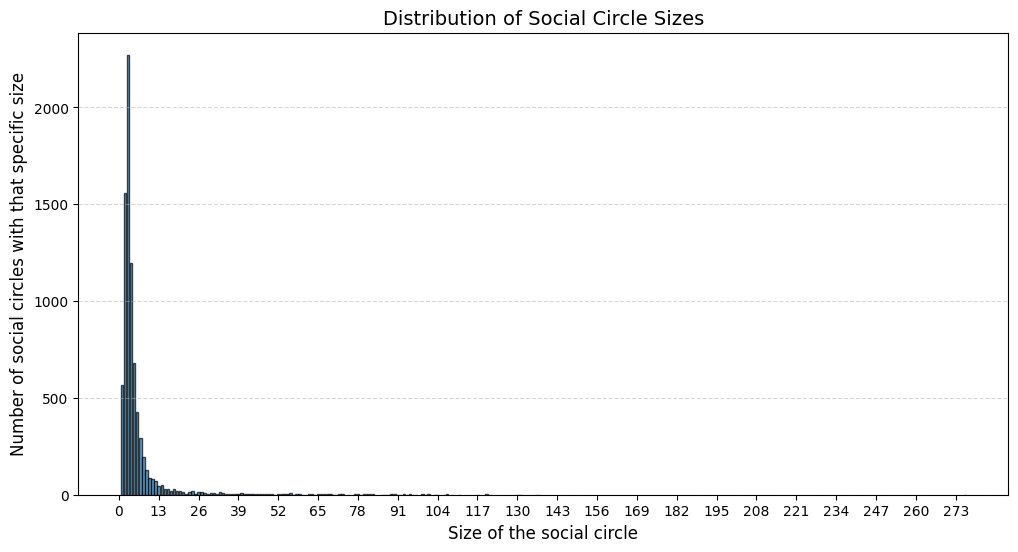

In [ ]:
# Find the sizes of the social circles
size = []
for i in circles_per_node.values():
  size.append(i)

# Find how many social circles have the same size
circle_size_counts = Counter(size)
print(circle_size_counts)
sizes = list(circle_size_counts.keys())
counts = list(circle_size_counts.values())

# Plot a histogram
plt.figure(figsize=(12,6))

plt.bar(sizes, counts, width=0.8, edgecolor="black", alpha=0.7)

plt.xlabel("Size of the social circle", fontsize=12)
plt.ylabel("Number of social circles with that specific size", fontsize=12)
plt.title("Distribution of Social Circle Sizes", fontsize=14)

# Adjusting xticks to avoid crowding
max_size = max(sizes)
step = max(1, max_size // 20)
plt.xticks(range(0, max_size+1, step))

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()

The computations show a network where influence is concentrated around a minority of well-connected actors, while most users connect to small, less cohesive groups. As before, we have proven that it is a core-periphery structure.

# Community detection

A community is a functionally meaningful sub-group within the network that has higher internal connectivity and lower external connectivity. Communities may represent groups of nodes that have similar purpose, ideas and functions.

From the results seen in the "graph metric" section, our graph is a scale-free network, meaning that a few nodes (hubs) have a significantly higher degree than the majority of the nodes.
Therefore, community sizes are often uneven, since some communities result in being tiny and dense, while others are large and loosely connected.

This results to be a problem for certain community detection algorithms, since they might miss small but meaningful communities, so we will test different algorithms to find the best one.

## Finding the communities within the graph

### Testing the effectiveness of different algorithms

With the function below we find certain characteristics of the communities detected.

In [ ]:
def community_detection(G, algorithm):
  print("Number of communities detected:", len(algorithm))
  print("--"*50)

  # Size of communities
  community_sizes = [len(community) for community in algorithm]

  # Print the sizes of the communities
  for i, size in enumerate(community_sizes, 1):
      print(f"Community {i}: Size {size}")
  print("--"*50)

  # Create a DataFrame with node and community membership
  l = []
  i = 0

  for community in algorithm:
    for node in community:
      l.append([node,i])
    i+=1

  df = pd.DataFrame(l, columns=['node','community'])
  df.sort_values(by='node', inplace=True)
  df.reset_index(drop=True, inplace=True)

  # Find crossing edges function
  def find_crossing_edges(G, df):
      crossing_edges = []

      for edge in G.edges():
        node1, node2 = edge
        community_node1 = int(df[df['node'] == node1 ]['community'].iloc[0])
        community_node2 = int(df[df['node'] == node2 ]['community'].iloc[0])

        if community_node1 != community_node2:
          crossing_edges.append(edge)

      return crossing_edges

  # Crossing edges
  crossing_edges = find_crossing_edges(G, df)
  print("Crossing Edges: ", crossing_edges)
  print(f"Number of crossing edges: {len(crossing_edges)}")

  node_counts = Counter(node for edge in crossing_edges for node in edge)
  print("Node counts: ", node_counts)
  print(f"Number of nodes with crossing edges: {sum(node_counts.values())}" )
  print("--"*50)

  return df, crossing_edges, node_counts

#### Greedy modularity-based approach

In [ ]:
# Applying the algorithm to the graph
comm_greedy = nx.community.greedy_modularity_communities(G)

In [ ]:
df_greedy, crossing_edges_greedy, node_counts_greedy = community_detection(G, comm_greedy)

Number of communities detected: 54
----------------------------------------------------------------------------------------------------
Community 1: Size 2254
Community 2: Size 2237
Community 3: Size 1422
Community 4: Size 1349
Community 5: Size 140
Community 6: Size 112
Community 7: Size 95
Community 8: Size 79
Community 9: Size 70
Community 10: Size 60
Community 11: Size 53
Community 12: Size 16
Community 13: Size 16
Community 14: Size 15
Community 15: Size 11
Community 16: Size 10
Community 17: Size 9
Community 18: Size 9
Community 19: Size 8
Community 20: Size 7
Community 21: Size 7
Community 22: Size 7
Community 23: Size 7
Community 24: Size 7
Community 25: Size 6
Community 26: Size 5
Community 27: Size 5
Community 28: Size 5
Community 29: Size 5
Community 30: Size 5
Community 31: Size 5
Community 32: Size 5
Community 33: Size 4
Community 34: Size 4
Community 35: Size 4
Community 36: Size 4
Community 37: Size 4
Community 38: Size 4
Community 39: Size 4
Community 40: Size 4
Communi

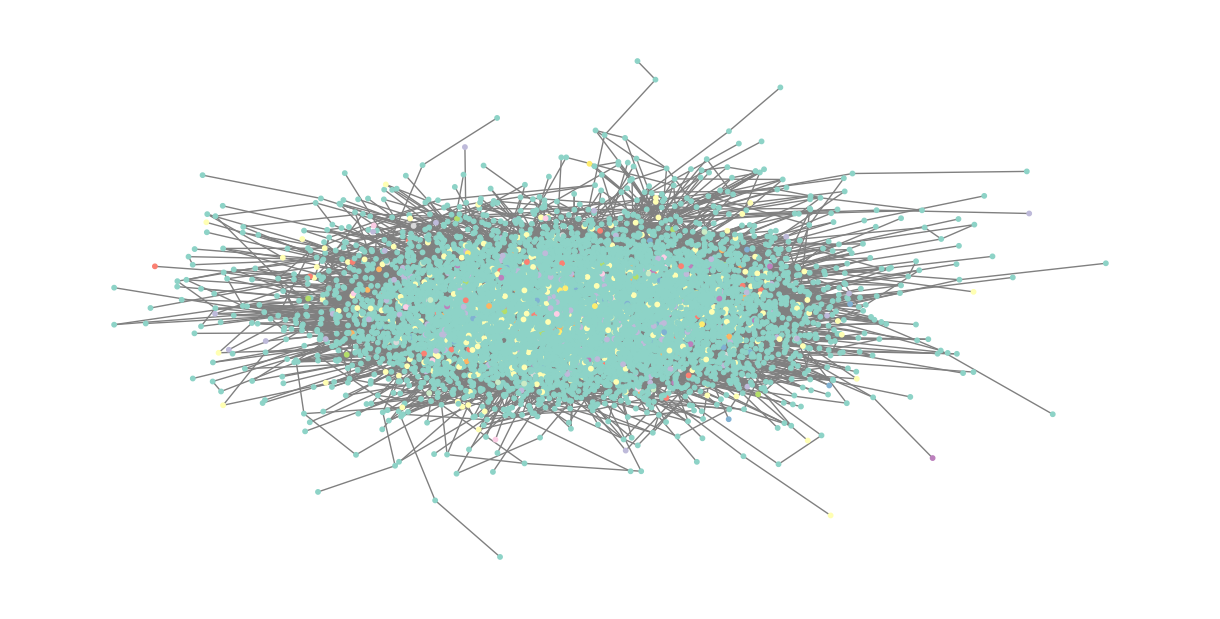

In [ ]:
# Plot the graph
plt.figure(figsize=(12,6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=10, node_color=df_greedy['community'], cmap=plt.cm.Set3, edge_color='gray')
plt.show()

#### Louvain modularity-based approach

In [ ]:
# Applying the algorithm to the graph
comm_louvain = nx.community.louvain_communities(G)

In [ ]:
df_louvain, crossing_edges_louvain, node_counts_louvain = community_detection(G, comm_louvain)

Number of communities detected: 16
----------------------------------------------------------------------------------------------------
Community 1: Size 517
Community 2: Size 2026
Community 3: Size 94
Community 4: Size 200
Community 5: Size 170
Community 6: Size 1298
Community 7: Size 917
Community 8: Size 342
Community 9: Size 724
Community 10: Size 192
Community 11: Size 602
Community 12: Size 227
Community 13: Size 335
Community 14: Size 365
Community 15: Size 57
Community 16: Size 47
----------------------------------------------------------------------------------------------------
Crossing Edges:  [('Can37', 'aRhythMetic'), ('Can37', 'rckid13'), ('Can37', 'DisregardMyComment'), ('IDontCareAboutYourPR', 'runner9272737373'), ('IDontCareAboutYourPR', 'Zealousideal-One1020'), ('rckid13', 'DingDongerer'), ('rckid13', 'Smallislandrunner'), ('rckid13', 'FirstTime5k'), ('rckid13', 'Bloomingcacti'), ('rckid13', 'withflyingcolors10'), ('rckid13', 'ithinkitsbeertime'), ('rckid13', 'NeonYel

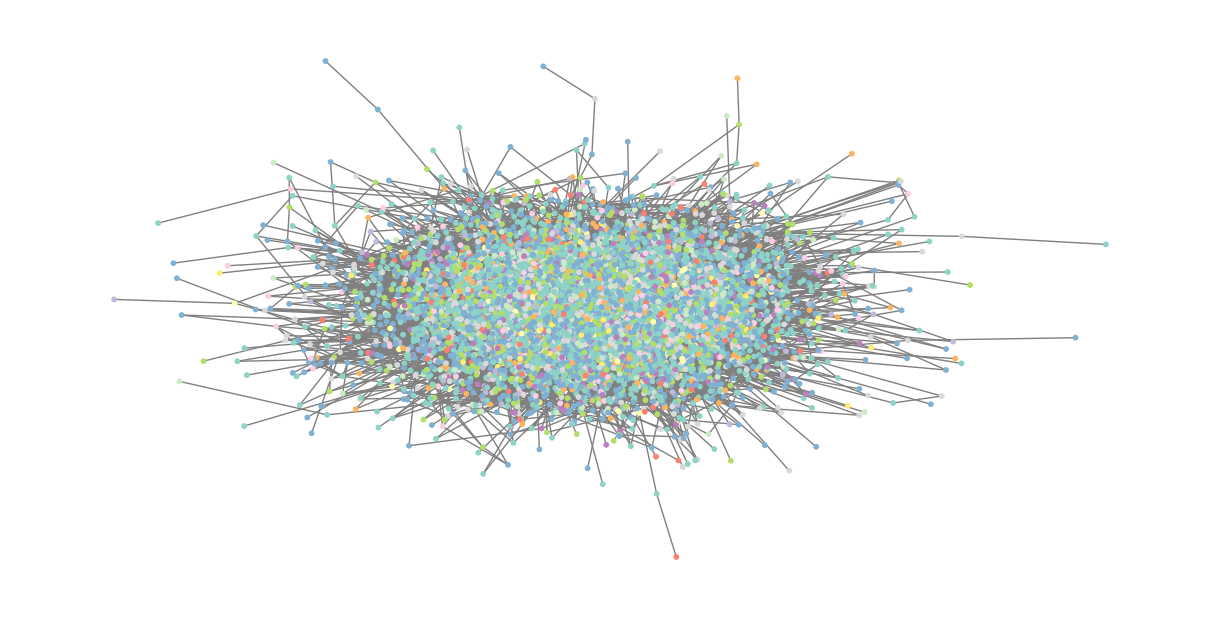

In [ ]:
# Plot the graph
plt.figure(figsize=(12,6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=10, node_color=df_louvain['community'], cmap=plt.cm.Set3, edge_color='gray')
plt.show()

#### FluidC graph-partitioning based approach

In [ ]:
# Applying the algorithm to the graph
comm_fluidC = list(nx.community.asyn_fluidc(G, k = 10)) # k: number of communities to be found

In [ ]:
df_fluidC, crossing_edges_fluidC, node_counts_fluidC = community_detection(G, comm_fluidC)

Number of communities detected: 10
----------------------------------------------------------------------------------------------------
Community 1: Size 792
Community 2: Size 807
Community 3: Size 835
Community 4: Size 846
Community 5: Size 809
Community 6: Size 788
Community 7: Size 808
Community 8: Size 822
Community 9: Size 774
Community 10: Size 832
----------------------------------------------------------------------------------------------------
Crossing Edges:  [('Can37', 'IDontCareAboutYourPR'), ('Can37', 'rckid13'), ('Can37', 'jondiced'), ('Can37', 'DisregardMyComment'), ('IDontCareAboutYourPR', 'runner9272737373'), ('IDontCareAboutYourPR', 'Zealousideal-One1020'), ('rckid13', 'DingDongerer'), ('rckid13', 'Smallislandrunner'), ('rckid13', 'FirstTime5k'), ('rckid13', 'ithinkitsbeertime'), ('rckid13', 'NeonYellowShoes'), ('rckid13', 'wedAVL2019'), ('rckid13', 'UltraTrailCoach'), ('rckid13', 'Mosquitoshite'), ('rckid13', 'summybsioa'), ('rckid13', 'AlarmingNectarine'), ('rckid1

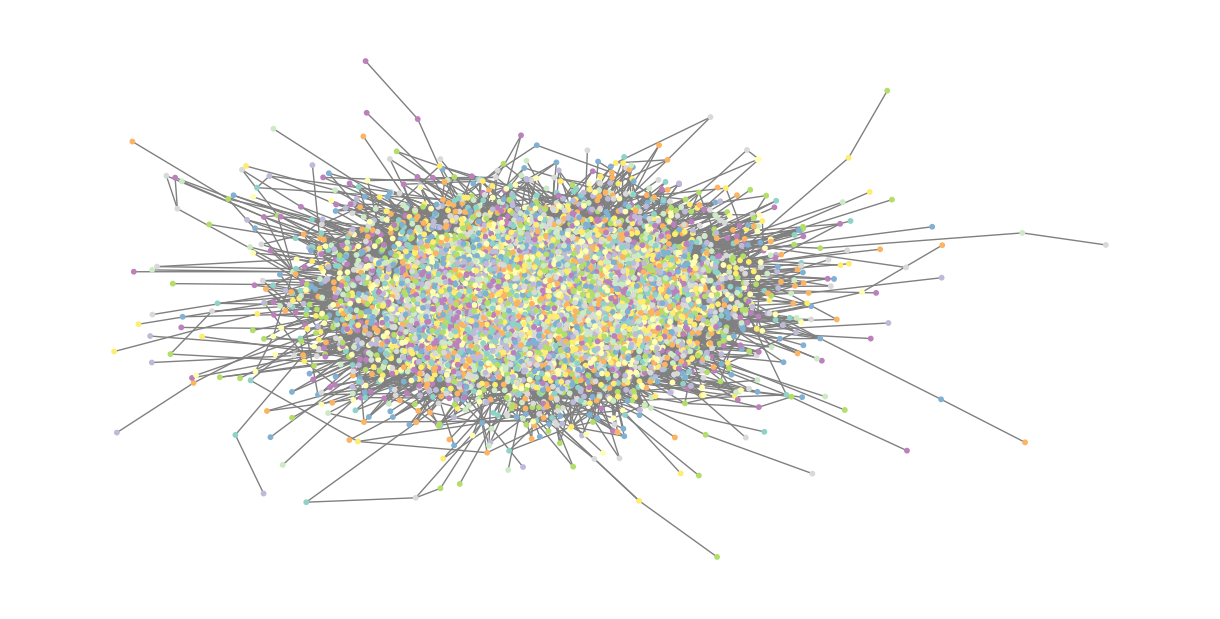

In [ ]:
# Plot the graph
plt.figure(figsize=(12,6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=10, node_color=df_fluidC['community'], cmap=plt.cm.Set3, edge_color='gray')
plt.show()

### Selecting the best algorithm

The modularity score is the most widely used score to compare algorithms, especially for modularity-based algorithms.

In [ ]:
# Compute the modularity score for each algorithm
score_greedy = nx.community.modularity(G, comm_greedy)
print(f"Greedy modularity-based approach's modularity score: {score_greedy}")

score_louvain = nx.community.modularity(G, comm_louvain)
print(f"Louvain modularity-based approach's modularity score: {score_louvain}")

score_fluidC = nx.community.modularity(G, comm_fluidC)
print(f"FluidC graph-partitioning based approach's modularity score: {score_fluidC}")

Greedy modularity-based approach's modularity score: 0.43586951799296897
Louvain modularity-based approach's modularity score: 0.4181186179572412
FluidC graph-partitioning based approach's modularity score: 0.334413408665736


From the results we find that the best algorithm is the greedy-modularity based approach-

## Evaluating the communities detected

In [ ]:
print("Number of communities detected:", len(comm_greedy))

Number of communities detected: 54


### Crossing edges

In [ ]:
num_crossing_edges_greedy = len(crossing_edges_greedy)

prop = num_crossing_edges_greedy / len(comm_greedy)
overall_prop = G.number_of_edges() / len(comm_greedy)

print("Proportion of crossing edges in a community:", prop/overall_prop)

Proportion of crossing edges in a community: 0.3192303713665046


On average, 32% of edges within a community are crossing edges, this means that the majority of the edges stay inside the community.

### Condunctance

The mean conductance is a measure of how well a community is separated from the rest of the network.

In [ ]:
# Finding the mean conductance
conductance_values = []
for community in comm_greedy:
  conductance_values.append(nx.algorithms.cuts.conductance(G, community))

print(conductance_values)

[0.24383561643835616, 0.2654981645209658, 0.4119846502017121, 0.3884068904815793, 0.5478260869565217, 0.5575539568345323, 0.5699797160243407, 0.5097493036211699, 0.5017301038062284, 0.4493927125506073, 0.5299145299145299, 0.5142857142857142, 0.5, 0.5692307692307692, 0.47368421052631576, 0.5833333333333334, 0.5675675675675675, 0.4838709677419355, 0.5172413793103449, 0.6, 0.5555555555555556, 0.625, 0.5, 0.5384615384615384, 0.6551724137931034, 0.5294117647058824, 0.6363636363636364, 0.6363636363636364, 0.42857142857142855, 0.5789473684210527, 0.5789473684210527, 0.42857142857142855, 0.5714285714285714, 0.4, 0.625, 0.5384615384615384, 0.45454545454545453, 0.5384615384615384, 0.38461538461538464, 0.45454545454545453, 0.5789473684210527, 0.5, 0.3333333333333333, 0.5, 0.5, 0.5555555555555556, 0.5, 0.5555555555555556, 0.5, 0.5555555555555556, 0.6666666666666666, 0.5, 0.3333333333333333, 0.5]


In [ ]:
conductance_values_mean = np.mean(conductance_values)
print("Mean conductance:", conductance_values_mean)

Mean conductance: 0.5096751319084043


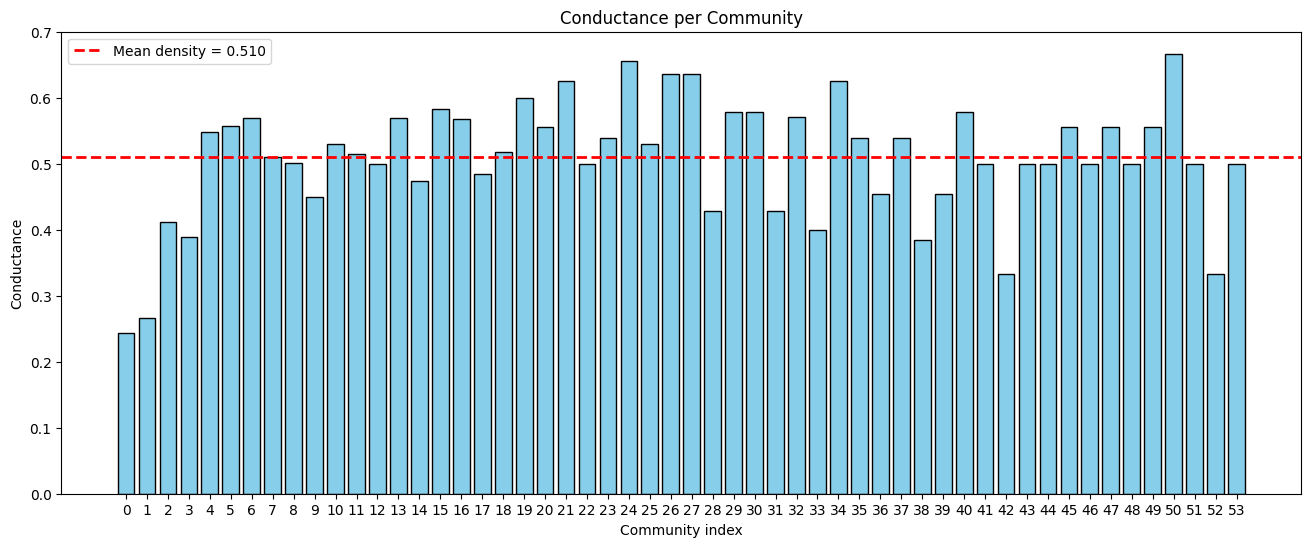

In [ ]:
# Plot histogram
plt.figure(figsize=(16,6))
x_values = range(len(comm_greedy))
plt.bar(x_values, conductance_values, color="skyblue", edgecolor="black")
plt.axhline(conductance_values_mean, color="red", linestyle="--", linewidth=2, label=f"Mean density = {conductance_values_mean:.3f}")
plt.title("Conductance per Community")
plt.xlabel("Community index")
plt.ylabel("Conductance")
plt.xticks(x_values)  # Show all community numbers on x-axis
plt.legend()
plt.show()

The mean conductance is quite high (in general a good value would be lower than 0.3), this suggests that many communities leak a lot of edges outside.

### Coverage

The coverage measures the fraction of edges that fall inside communities compared to all edges in the graph.

In [ ]:
# Map each node to its community index
node_to_comm = {}
for i, comm in enumerate(comm_greedy):
  for node in comm:
    node_to_comm[node] = i

# Count intra-community edges
intra_edges = 0
for u, v in G.edges():
  if node_to_comm[u] == node_to_comm[v]:
    intra_edges += 1

coverage = intra_edges / G.number_of_edges()
print("Coverage:", coverage)

Coverage: 0.6807696286334954


68% of all edges are intra-community, which shows that the network is not well-separated, since a good percentage would be greater than 75-80%.

### Intra-community Density

In [ ]:
comm_density = []
for community in comm_greedy:
  comm_density.append(nx.density(G.subgraph(community)))

print(comm_density)

[0.002500067936628713, 0.0028401025843614027, 0.0029574466189793247, 0.002674802524344882, 0.016032887975334018, 0.019787644787644786, 0.02374020156774916, 0.028562155144433627, 0.02981366459627329, 0.0384180790960452, 0.03991291727140784, 0.14166666666666666, 0.125, 0.13333333333333333, 0.18181818181818182, 0.2222222222222222, 0.2222222222222222, 0.2222222222222222, 0.25, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.3333333333333333, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6666666666666666, 0.5, 0.6666666666666666, 0.5, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Mean density
mean_density = np.mean(comm_density)
print("Mean density:", mean_density)

Mean density: 0.3876721527251756


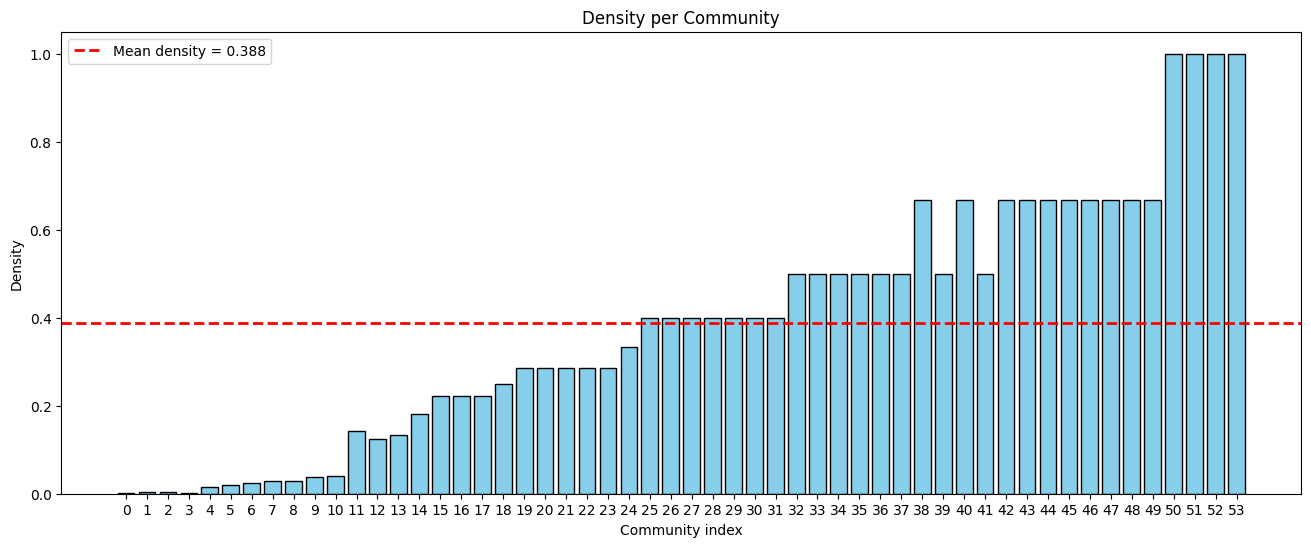

In [ ]:
# Plot histogram
plt.figure(figsize=(16,6))
x_values = range(len(comm_greedy))
plt.bar(x_values, comm_density, color="skyblue", edgecolor="black")
plt.axhline(mean_density, color="red", linestyle="--", linewidth=2, label=f"Mean density = {mean_density:.3f}")
plt.title("Density per Community")
plt.xlabel("Community index")
plt.ylabel("Density")
plt.xticks(x_values)  # Show all community numbers on x-axis
plt.legend()
plt.show()

Densities span a big range, going from big communities with density ~0.002–0.04 to small ones that have desities of 0.4–1.0.

This indicates that the small communities were clearly captured, while the large ones are very sparse, which also lowers the conductance quality and the mean density.

## Sentiment propagation

Note: a few authors will be missing becuase they have been added when extracting more comments and are not present in the original dataset:

In [ ]:
list_of_communities = [community for community in comm_greedy]

rows = []
for community in comm_greedy:
    member_texts = []
    for author in community:
        if author in df['author'].values:
            texts_for_author = df.loc[df['author'] == author, 'text'].tolist()
            member_texts.extend(texts_for_author)
    combined_text = " ".join(member_texts).strip()

    if combined_text:  # only keep non-empty
        rows.append({
            "members": list(community),
            "n_members": len(community),
            "combined_text": combined_text
        })

# convert to dataframe
communities_df = pd.DataFrame(rows)
communities_df.head()

members  n_members  \
0  [Philmore, MoonPlanet1, Extension-Tap2635, i46...       2254   
1  [Gillhooley, negedgeClk, ptm93, AptCasaNova, s...       2237   
2  [13point1then420, redranrye, white_tailed_derp...       1422   
3  [TheGink, balleklorin, Funny_Public_4695, lucy...       1349   
4  [JonstheSquire, justaboringname, Skips-mamma-l...        140   

                                       combined_text  
0  This is for the people who Run in underwear I ...  
1  I've entered a marathon in October and I'm int...  
2  Running doesn’t wreck your knees. It strengthe...  
3  Buy It For Life winter running gear suggestion...  
4  Ryan Hall, Fastest U.S. Distance Runner, is Re...

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def vader_score(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']

communities_df["vader"] = communities_df["combined_text"].apply(vader_score)
communities_df

members  n_members  \
0   [Philmore, MoonPlanet1, Extension-Tap2635, i46...       2254   
1   [Gillhooley, negedgeClk, ptm93, AptCasaNova, s...       2237   
2   [13point1then420, redranrye, white_tailed_derp...       1422   
3   [TheGink, balleklorin, Funny_Public_4695, lucy...       1349   
4   [JonstheSquire, justaboringname, Skips-mamma-l...        140   
5   [banditgirl, 12panel, JudgeJuryEx78, astridtm,...        112   
6   [overripavacado, nitropuppy, rinzler83, Falawf...         95   
7   [Dangerous_Pitch_3992, martyrunner, torontorun...         79   
8   [MikeOne29, JamesBonderful, Y_E_double-YEW, AL...         70   
9   [Accomplished_Class72, Andr3wRuns, runningmom2...         60   
10  [mandabee27, fuckedbymath, robynbird05, llambd...         16   
11  [accidentalcrash, Micosilver, RIPEOTCDXVI, zle...         15   
12  [DangerousCranberry, afhill, cbkimrey, tohellu...         11   
13  [Runannon, Technics3345, Taroni99, spaceship4p...          7   
14  [helbnd, ranger662, MintStem67, bapohh, Which_...          6   
15  [maisondejambons, CaliQuakes510, ThatWasJustTh...          4   
16             [krycek519, browhodouknowhere, motank]          3   

                                        combined_text   vader  
0   This is for the people who Run in underwear I ...  1.0000  
1   I've entered a marathon in October and I'm int...  1.0000  
2   Running doesn’t wreck your knees. It strengthe...  1.0000  
3   Buy It For Life winter running gear suggestion...  1.0000  
4   Ryan Hall, Fastest U.S. Distance Runner, is Re...  0.9546  
5   3 years ago, I collapsed (heat stroke + seizur...  0.9989  
6   Does anyone know of an app that you can put in...  0.9952  
7   Most difficult distanceObviously every race, i...  0.1751  
8   Safe Spots to run in Minneapolis during the wi...  0.9717  
9   Chicago Hoka Half Marathon Incorrect DistanceP...  0.9872  
10  Cardiologist resuscitates two fellow runners d...  0.6226  
11  How to Train Like a Pro: Part 3 - Hill Repeats...  0.9994  
12  Race Report: Sydney Marathon - Racing the Heat...  0.9997  
13  Ran my FIRST Ultra + FIRST Marathon Distance o...  0.9995  
14  thinking of running regularly but still overwe...  0.9784  
15  Recommend me a fall/winter road half in wester...  0.9971  
16  5 months ago I couldn't run 100m with out been... -0.0804

In [ ]:
communities_df["sentiment"] = communities_df["vader"].apply(
    lambda x: "positive" if x >= 0.05 else "negative" if x <= -0.05 else "neutral"
)

In [ ]:
communities_df

members  n_members  \
0   [Philmore, MoonPlanet1, Extension-Tap2635, i46...       2254   
1   [Gillhooley, negedgeClk, ptm93, AptCasaNova, s...       2237   
2   [13point1then420, redranrye, white_tailed_derp...       1422   
3   [TheGink, balleklorin, Funny_Public_4695, lucy...       1349   
4   [JonstheSquire, justaboringname, Skips-mamma-l...        140   
5   [banditgirl, 12panel, JudgeJuryEx78, astridtm,...        112   
6   [overripavacado, nitropuppy, rinzler83, Falawf...         95   
7   [Dangerous_Pitch_3992, martyrunner, torontorun...         79   
8   [MikeOne29, JamesBonderful, Y_E_double-YEW, AL...         70   
9   [Accomplished_Class72, Andr3wRuns, runningmom2...         60   
10  [mandabee27, fuckedbymath, robynbird05, llambd...         16   
11  [accidentalcrash, Micosilver, RIPEOTCDXVI, zle...         15   
12  [DangerousCranberry, afhill, cbkimrey, tohellu...         11   
13  [Runannon, Technics3345, Taroni99, spaceship4p...          7   
14  [helbnd, ranger662, MintStem67, bapohh, Which_...          6   
15  [maisondejambons, CaliQuakes510, ThatWasJustTh...          4   
16             [krycek519, browhodouknowhere, motank]          3   

                                        combined_text   vader sentiment  
0   This is for the people who Run in underwear I ...  1.0000  positive  
1   I've entered a marathon in October and I'm int...  1.0000  positive  
2   Running doesn’t wreck your knees. It strengthe...  1.0000  positive  
3   Buy It For Life winter running gear suggestion...  1.0000  positive  
4   Ryan Hall, Fastest U.S. Distance Runner, is Re...  0.9546  positive  
5   3 years ago, I collapsed (heat stroke + seizur...  0.9989  positive  
6   Does anyone know of an app that you can put in...  0.9952  positive  
7   Most difficult distanceObviously every race, i...  0.1751  positive  
8   Safe Spots to run in Minneapolis during the wi...  0.9717  positive  
9   Chicago Hoka Half Marathon Incorrect DistanceP...  0.9872  positive  
10  Cardiologist resuscitates two fellow runners d...  0.6226  positive  
11  How to Train Like a Pro: Part 3 - Hill Repeats...  0.9994  positive  
12  Race Report: Sydney Marathon - Racing the Heat...  0.9997  positive  
13  Ran my FIRST Ultra + FIRST Marathon Distance o...  0.9995  positive  
14  thinking of running regularly but still overwe...  0.9784  positive  
15  Recommend me a fall/winter road half in wester...  0.9971  positive  
16  5 months ago I couldn't run 100m with out been... -0.0804  negative

All the communities that were identified developed towards a positive note